In [ ]:
import numpy as np
import random
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import multivariate_normal, chi2
import time
import pandas as pd


p = 0

Feval = []
F_final = []
Ngen = []
CPU = []

while p<20:

    # Define the intervals
    x_interval = [1, 5]
    y_interval = [1, 5]

    # Generate a random x coordinate within the specified interval
    x_coordinate = random.uniform(x_interval[0], x_interval[1])

    # Generate a random y coordinate within the specified interval
    y_coordinate = random.uniform(y_interval[0], y_interval[1])

    # Create a NumPy array representing the sampled point
    sampled_point = np.array([x_coordinate, y_coordinate])


    # sampled_point = np.array([2.1167525, 2.17627461])

    print("Sampled Point:", sampled_point)



    # Define the interval
    interval = [1, 5]

    # Calculate half of the interval length
    half_interval_length = (interval[1] - interval[0]) / 2

    # Print the result
    print("Half of the interval length:", half_interval_length)



    g = 200 # no. of generations to run (no. of iterations)
    k = 0  # iteration count
    n = 2  # no. of variables in the objective function (dimension)
    l_def = l_ng = l = 4 + math.floor(3*np.log(n))
    l_max = 512*l_def


    F=[]        # To store the function value at each iteration
    Mean = []   # To store the mean value at each iteration
    Cov = []    # To store the covariance matrix at each iteration
    ch = []     # To store the shift in mean at each iteration
    pop = []    # To store the population size at every generation
    sigCSA = [] # To store the step size change by CSA at every generation
    sigTot = [] # To store the total step size change at every generation (step-size correction)
    real_l = [] # To store the found l value
    fixed_l = [] # considered l
    pthetval = []
    psignorm = [] # To consider psignorm values
    hsigma = []
    psigvec = []
    st_sng = []
    st_spg = []
    st_div = []
    adapt = []
    potsig = []
    inval_pg = []
    inval_ng = []
    normval_pg = []
    normval_ng = []

    l_ng = l_def   # population size starts with default population size
    I = l_ng      # Initial population = I

#     m = np.array([1, 1])
#     c = np.array([[1, 0], [0, 1]])
#     zero = np.array([0,0])
#     psigng = np.array([0,0])
#     pcng = np.array([0,0])     # Because pc = 0 at gen 0
#     p_thetng = np.array([0,0,0,0,0]) # Because p_theta = 0 at gen 0

    m = sampled_point
    c = np.eye(2)
    sig = half_interval_length

    zero = np.zeros(n)
    psigng = np.zeros(n)
    pcng = np.zeros(n)     # Because pc = 0 at gen 0
    p_thetng = np.zeros(int(n*(n+3)/2)) # Because p_theta = 0 at gen 0

    Mean.append(m)
    Cov.append(c)

    real_l.append(l)
    fixed_l.append(l_ng)
    psigvec.append(psigng)

    gam_signg = 0      # normalization factor for p_sigma
    gam_cng = 0        # normalization factor for pc
    gam_thetng = 0     # normalization factor for p_theta
    alpha = 1.4        # for PSA update - population size correction
    beta = 0.4         # for PSA update - p_theta update

    sigTot.append(sig)

    start_time = time.process_time()

    while k<g:

        I = l_ng
        pc = pcng          # pc equals the pc of next generation
        psig = psigng      # psig equals the psig of next generation
        p_thet = p_thetng  # p_theta equals the p_theta of next generation
        gam_sig = gam_signg
        gam_c = gam_cng
        gam_thet = gam_thetng


        # assigning weights

        mu = math.floor(I/2)
        w_k = []       # weight vector - contains weights for all I
        denom = 0      # denominator for eack w_k_i
        for i in range(1,mu+1):
            denom = denom + (np.log((mu+0.5)) - np.log(i))

        for i in range(1, mu + 1):
            w_k_i = (np.log((mu + 0.5)) - np.log(i)) / denom
            w_k.append(w_k_i)
        for i in range(mu+1,I+1):
            w_k_i = 0
            w_k.append(w_k_i)

        # define mu_eff, c1, c_mu, c_sig, d_sig, cm, Cc

        mu_eff = 1 / np.sum(np.square(w_k))                            # mu_eff = 1/sum(w_i**2)
        c1 = 2/((n+1.3)**2 + mu_eff)                                   # Value from 2018 paper
        c_mu = min(1, (2*(mu_eff - 2 +1)/mu_eff)/((n+2)**2 + mu_eff))  # min(1, (2(mu_eff - 2 +1)/mu_eff)/((n+2)**2 + mu_eff))
        c_sig = (mu_eff+2)/(n+mu_eff+5)
        d_sig = 1 + c_sig  + 2*(max(0, (np.sqrt((mu_eff-1)/(n+1))-1))) # 1 + c_sig + 2*max{ 0, sqrt((mu_eff-1)/(n+1))-1 }
        cm = 1                                                         # Learning parameter is set to 1
        Cc = (4 + (mu_eff/n))/(n + 4 + (2*mu_eff/n))                   # Cc (value from 2018 PSA_CMA_ES paper)

        px=[]
        py=[]

        while(len(px)<I):
            d =  m + sig * np.random.multivariate_normal(zero, c)
            if (d[0] <= 10) and (d[1] <= 10) and (d[0] >= -10) and (d[1] >= -10):
                px.append(d[0])
                py.append(d[1])

        # keep old values
        mpg = m       # old m value
        c_old = c     # old c value
        sigpg = sig   # old sig value


        # select i:l_r values

        b = [((x**2 + 10*(1 - np.cos(2*np.pi*x))) + (y**2 + 10*(1 - np.cos(2*np.pi*y)))) for x, y in zip(px, py)]    # Calculate the sum of each px[i]+py[i] and store in list b

        best = sorted(b)     # Sort b in lows

        bx = [px[b.index(val)] for val in best]    # Find the corresponding px[i] and py[i]
        by = [py[b.index(val)] for val in best]    #       values for each element in 'best'

        print("\n")
#         print("Candidate solutions")
#         for i in range(len(bx)):
#             print("At ",k,": (",bx[i],",",by[i],")")

        bestx = []
        besty = []
        for i in range(len(bx)):
            bbx = w_k[i]*(bx[i] - m[0])
            bby = w_k[i]*(by[i] - m[1])
            bestx.append(bbx)
            besty.append(bby)

        dmx = cm * sum(bestx)
        dmy = cm * sum(besty)

        # mean vector update

        mx = m[0] + dmx      # update vector m - x-coordinate
        my = m[1] + dmy      # update vector m - y-coordinate

        m = np.array([mx,my])  # m - next generation

#         print("\n")
        print("Mean for ",k+1," = ",m)


        ch.append(m-mpg)   #To calculate the change in mean at each iteration

#         print("m[",k+1,"] - m[",k,"]", ch[k])


#         plt.figure(2*k)
#         plt.scatter(px, py, color='b', label='{}th population'.format(k+1))
#         plt.scatter(m[0], m[1], color='r', label='Mean at {}th generation'.format(k+1))
#         plt.xlabel('X')
#         plt.ylabel('Y')
#         plt.title('x[{}] th generation'.format(k + 1))
#         plt.legend()
#         plt.grid()

        # Getting the eigendecompostion of c for the CSA update

#         print("\n")
#         print("p_sigma path signal understanding")
        eigenvalues, eigenvectors = np.linalg.eig(c) # Eigendecomposition of c
        if any(eigval < 0 for eigval in eigenvalues):
            print("At k=",k+1,", matrix is not PSD")
        B = eigenvectors                             # Ensure eigenvectors are normalized (orthogonal matrix)
#         print("Eigenvectors: ")
#         print(B)
        D = np.diag(np.sqrt(eigenvalues))            # Diagonal matrix D with square roots of eigenvalues
#         print("Eigenvalues")
#         print(D)
        D_inv = np.diag(1 / np.sqrt(eigenvalues))    # Calculate the inverse of D
        c_inv_half = B @ D_inv @ B.T                 # Calculate C^(-1/2) = B * D^(-1) * B^T
#         print("c_inv_half")
#         print(c_inv_half)



        # Evolution path p_sigma for CSA update (p_sigma is 2x1)

        psigng0 = (1-c_sig)*psig[0] + math.sqrt((c_sig*(2 - c_sig)*mu_eff))*(1/sig)*(c_inv_half[0][0]*dmx + c_inv_half[0][1]*dmy)
        psigng1 = (1-c_sig)*psig[1] + math.sqrt((c_sig*(2 - c_sig)*mu_eff))*(1/sig)*(c_inv_half[1][0]*dmx + c_inv_half[1][1]*dmy)
        gam_signg = ((1-c_sig)**2)*gam_sig + c_sig*(2-c_sig)   # normalization p_sigma

        psigng = np.array([psigng0,psigng1])

        psigvec.append(psigng)

#         print("\n")
#         print("Evolution path p_sigma = ",psigng)

        # Evolution path pc for rank-one update (pc is 2x1)

        chi = (math.sqrt(n))*(1 - (1/(4*n)) + (1/(21*n**2))) # E[||N(0,I)||]
        psig_vector = np.array([[psigng[0]], [psigng[1]]])   # Define a psigng as a 2x1 matrix
        norm_psig = np.linalg.norm(psig_vector)              # Calculate the 2-norm (Euclidean norm)

#         print("\n")
#         if norm_psig < chi:
#             print("norm_psig < expected length --> CSA decreased")
#         else:
#             print("norm_psig >= expected length --> CSA increased")
        cond = (1.4 + 2/(n+1))*chi*(math.sqrt(gam_signg))    # condition for h_sigma

        psignorm.append(norm_psig)

        if norm_psig<cond:
            h_sig = 1
        else:
            h_sig = 0

        hsigma.append(h_sig)

        pcng0 = (1-Cc)*pc[0] + h_sig*(math.sqrt((Cc*(2 - Cc)*mu_eff)))*(1/sig)*dmx  # x-coordinate
        pcng1 = (1-Cc)*pc[1] + h_sig*(math.sqrt((Cc*(2 - Cc)*mu_eff)))*(1/sig)*dmy  # y-coordinate
        gam_cng = ((1-Cc)**2)*gam_c + h_sig*Cc*(2-Cc)   # normalization pc

        pcng = np.array([pcng0,pcng1])

        sigA = sig

        # step size update (sigma)

        exp_val = (c_sig/d_sig)*((norm_psig/chi) - (math.sqrt(gam_signg)))
        sig = sig*(math.exp(exp_val))

        sigB = sig

#         print("||P_sig||/chi = ",(norm_psig/chi))
#         print("\n")
#         print("sig * exp(",exp_val,")")
#         print("step-size after CSA correction : ")
#         print(sig)

        sigCSA.append(sig)



        # rank-mu update

        dift_x = []  # string to hold x - m := x-coordinate
        dift_y = []  # string to hold x - m := y-coordinate
        cmat00 = []  # 00 element of (x-m).(x-m)^T outer product
        cmat01 = []  # 01 element of (x-m).(x-m)^T outer product
        cmat10 = []  # 10 element of (x-m).(x-m)^T outer product
        cmat11 = []  # 11 element of (x-m).(x-m)^T outer product

        for i in range(len(bx)):
            difx = bx[i] - m[0]
            dify = by[i] - m[1]
            dift_x.append(difx)
            dift_y.append(dify)
        for i in range(len(bx)):
            c00 = w_k[i]*(dift_x[i]*dift_x[i] - c[0][0])
            c01 = w_k[i]*(dift_x[i]*dift_y[i] - c[0][1])
            c10 = w_k[i]*(dift_x[i]*dift_y[i] - c[1][0])
            c11 = w_k[i]*(dift_y[i]*dift_y[i] - c[1][1])
            cmat00.append(c00)
            cmat01.append(c01)
            cmat10.append(c10)
            cmat11.append(c11)

        cRank_mu = np.zeros((2,2))
        cRank_mu[0][0] = sum(cmat00)
        cRank_mu[0][1] = sum(cmat01)
        cRank_mu[1][0] = sum(cmat10)
        cRank_mu[1][1] = sum(cmat11)


        # rank-one update

        cRank_1 = np.zeros((2,2))
        cRank_1[0][0] = pcng[0]*pcng[0] - gam_cng*c[0][0]
        cRank_1[0][1] = pcng[0]*pcng[1] - gam_cng*c[0][1]
        cRank_1[1][0] = pcng[1]*pcng[0] - gam_cng*c[1][0]
        cRank_1[1][1] = pcng[1]*pcng[1] - gam_cng*c[1][1]

        # Covariance matrix update

        c = c + c1*cRank_1 + c_mu*cRank_mu



        ##    ***  PSA update  ***

        # 1 - Approximate FIM

        fim = c_inv_half

        # 2 - Calculate Deltha_Theta

        dtheta = np.array([0,0,0,0,0])
        dtheta0 = fim[0][0]*(dmx) + fim[0][1]*(dmy)
        dtheta1 = fim[0][1]*(dmx) + fim[1][1]*(dmy)
        dtheta2 = (sig**2)*(c[0][0]) - (sigpg**2)*(c_old[0][0])
        dtheta3 = (sig**2)*(c[0][1]) - (sigpg**2)*(c_old[0][1])
        dtheta4 = (sig**2)*(c[1][1]) - (sigpg**2)*(c_old[1][1])

#         print("\n")
#         print("I^(1/2)*Dtheta (5x1)-vector")


        dtheta = np.array([dtheta0,dtheta1,dtheta2,dtheta3,dtheta4])

#         print("     dmx         dmy    sig*dC[0][0] sig*dC[0][1] sig*dC[1][1]")
#         print(dtheta)

        # 3 - Find terms of E[ ||.|| ]

        w_k_i3 = 0                        # sum(wi^3)
        for i in range(len(w_k)):
            w_k_i3 = w_k_i3 + w_k[i]**3

        E1  = n*(cm**2)/mu_eff
        E2  = (2*n)*((n - chi**2)/(chi**2))*gam_signg*((c_sig/d_sig)**2)
        E3a = (n**2 + n)*(c_mu**2)/mu_eff
        E3b = (n**2 + n)*(Cc)*(2 - Cc)*(c1)*(c_mu)*(mu_eff)*(w_k_i3)
        E3c = (c1**2)*(gam_cng**2)*(n**2)
        E3d = 1 - (2*gam_cng) + 2*n*(gam_cng**2)
        E3e = 1 + (8*(gam_signg)*((n - chi**2)/(chi**2))*((c_sig/d_sig)**2))
        E3  = (1/2)*E3e*(E3a + E3b + E3c + E3d)

        # 4 - Approximation for E[ ||.|| ]

        Efim = E1 + E2 + E3

        Efim_rt = math.sqrt(Efim)  # E[|| fim.dtheta ||]^(1/2)

        # Evolution path p_theta for PSA update (p_theta is 5x1) ( R^(n(n+3)/2) )

        p_thetng0 = (1 - beta)*p_thet[0] + (1/Efim_rt)*(math.sqrt((beta*(2 - beta))))*(dtheta[0])
        p_thetng1 = (1 - beta)*p_thet[1] + (1/Efim_rt)*(math.sqrt((beta*(2 - beta))))*(dtheta[1])
        p_thetng2 = (1 - beta)*p_thet[2] + (1/Efim_rt)*(math.sqrt((beta*(2 - beta))))*(dtheta[2])
        p_thetng3 = (1 - beta)*p_thet[3] + (1/Efim_rt)*(math.sqrt((beta*(2 - beta))))*(dtheta[3])
        p_thetng4 = (1 - beta)*p_thet[4] + (1/Efim_rt)*(math.sqrt((beta*(2 - beta))))*(dtheta[4])

        gam_thetng = ((1 - beta)**2)*gam_thet + beta*(2 - beta)
        # p_thetng = np.array([[p_thetng0], [p_thetng1], [p_thetng2], [p_thetng3], [p_thetng4]])
        p_thetngval = p_thetng0**2 + p_thetng1**2 + p_thetng2**2 + p_thetng3**2 + p_thetng4**2

#         print("p_theta evolution path (5x1)")
#         print(p_thetng)

        # Update population size

        # norm_pthet = np.linalg.norm(p_thetng)     # Calculate the 2-norm (Euclidean norm) of p_theta
        norm_pthet = math.sqrt(p_thetngval)

        exp_val2 = beta*(gam_thetng - (norm_pthet**2)/alpha)

#         print("beta*exp(val2)")
#         print("val2 = ",(gam_thetng - (norm_pthet**2)/alpha))

#         print("norm of ptheta = ",norm_pthet)
#         print("\n")

        pthetval.append(norm_pthet)

        l = l*math.exp(exp_val2)

#         print("real l = ",l)
        reall=l
        real_l.append(l)

        l = min(max(l,l_def),l_max)
        l_pg = l_ng   # keep old population size
        l_ng = round(l)

        fixed_l.append(l_ng)


#         print("fixd l = ",l_ng)

#         print("\n")
#         print("Step size correction")

        # step size correction

        # Generating (lamda_r)^(t+1) to find E[N_i:Lr]

        lpx = []
        lpy = []

        while(len(lpx)<l_ng):
            ld =  m + sig * np.random.multivariate_normal(zero, c)
            if (ld[0] <= 10) and (ld[1] <= 10) and (ld[0] >= -10) and (ld[1] >= -10):
                lpx.append(ld[0])
                lpy.append(ld[1])

        lb = [((x**2 + 10*(1 - np.cos(2*np.pi*x))) + (y**2 + 10*(1 - np.cos(2*np.pi*y)))) for x, y in zip(lpx, lpy)]    # Calculate the sum of each px[i]+py[i] and store in list b

        lbest = sorted(lb)     # Sort b in lows

        lbx = [lpx[lb.index(val)] for val in lbest]    # Find the corresponding px[i] and py[i]
        lby = [lpy[lb.index(val)] for val in lbest]    #       values for each element in 'best'

        # weights for (lamda_r)^(t+1)
        lw_k = []       # weight vector - contains weights for all I
        ldenom = 0      # denominator for eack w_k_i
        lmu = math.floor(l_ng/2)
        for i in range(1,l_ng+1):
            ldenom = ldenom + (np.log((l_ng+0.5)) - np.log(i))

        for i in range(1, lmu + 1):
            lw_k_i = (np.log((l_ng + 0.5)) - np.log(i)) / ldenom
            lw_k.append(lw_k_i)
        for i in range(lmu+1,l_ng+1):
            lw_k_i = 0
            lw_k.append(lw_k_i)

        lmu_eff = 1 / np.sum(np.square(lw_k))

        #finding phi^(-1)
        al = 0.375
        prob_pg = []
        prob_ng = []

        inval_pg = []
        normval_pg = []

        for i in range(len(bx)):
            valp = (i+1-al)/(len(bx)+1-2*al)
            inval_pg.append(valp)
            phipg = norm.ppf(valp)
            normval_pg.append(phipg)

            mxppg = w_k[i]*(mpg[0] + sigpg*(phipg))
            myppg = w_k[i]*(mpg[1] + sigpg*(phipg))
            exp_pg = math.sqrt((mxppg**2 + myppg**2))
            prob_pg.append(exp_pg)


#             mxppg = w_k[i]*(mpg[0] + sigpg*(norm.ppf((i+1)/(len(bx)+1))))
#             myppg = w_k[i]*(mpg[1] + sigpg*(norm.ppf((i+1)/(len(bx)+1))))
#             exp_pg = math.sqrt((mxppg**2 + myppg**2))
#             prob_pg.append(exp_pg)
            #exp_pg = mxppg

#         print("\n")
#         print("At generation",k,"P(x) value for L_g =")
#         print(inval_pg)
#         print("At generation",k,"phi(-1) value for L_g =")
#         print(normval_pg)
#         print("\n")


        inval_ng = []
        normval_ng = []

        for i in range(len(lbx)):
            valn = (i+1-al)/(len(lbx)+1-2*al)
            inval_ng.append(valn)
            phing = norm.ppf(valn)
            normval_ng.append(phing)

            mxpng = lw_k[i]*(m[0] + sig*(phing))
            mypng = lw_k[i]*(m[1] + sig*(phing))
            exp_ng = math.sqrt((mxpng**2 + mypng**2))
            prob_ng.append(exp_ng)

#             mxpng = lw_k[i]*(m[0] + sig*(norm.ppf((i+1)/(len(lbx)+1))))
#             mypng = lw_k[i]*(m[1] + sig*(norm.ppf((i+1)/(len(lbx)+1))))
#             exp_ng = math.sqrt((mxpng**2 + mypng**2))
#             #exp_ng = mxpng
#             prob_ng.append(exp_ng)
#         print("\n")
#         print("At generation",k,"P(x) value for L_g+1 =")
#         print(inval_ng)
#         print("At generation",k,"phi(-1) value for L_g+1 =")
#         print(normval_ng)
#         print("\n")


#         print("phi^(-1)_pg = ",phipg)
#         print("phi^(-1)_ng = ",phing)

#         print("\n")

#         print("weighted expected values of NOS")
#         print("\n")

#         print("E[l_r^(g)] = ",prob_pg)
#         print("E[l_r^(g+1)] = ",prob_ng)

#         print("sum{E[l_r^(g)]} = ",sum(prob_pg))
#         print("sum{E[l_r^(g+1)]} = ",sum(prob_ng))

#         print("\n")

        cpg = (-1)*sum(prob_pg)
        cng = (-1)*sum(prob_ng)
        sigfunc_pg = (cpg*n*mu_eff)/(n - 1 + (cpg**2)*mu_eff)
        sigfunc_ng = (cng*n*lmu_eff)/(n - 1 + (cng**2)*lmu_eff)

#         print("lr(g+1) = ",sigfunc_ng)
#         print("lr(g) = ",sigfunc_pg)
#         print("lr(g+1)/lr(g) = ",sigfunc_ng/sigfunc_pg)
#         print("\n")
#         print("st-s b4 correction = ",sig)
        # step size correction

        st_sng.append(sigfunc_ng)
        st_spg.append(sigfunc_pg)
        st_div.append(sigfunc_ng/sigfunc_pg)


        # # ORIGINAL
        # sig = sig*((sigfunc_ng/sigfunc_pg))


        # # CASE 1
        # if abs(l_ng - l_pg) < 6:
        #     if norm_psig >= chi:
        #         sig = sig
        #         print("step-size correction not done as CSA request step-size increase")
        #     else:
        #         sig = sig*(0.5*(sigfunc_ng/sigfunc_pg))
        #         print("scaled step-size correction (pop-dif < 10)")

        # else:
        #     if norm_psig >= chi:
        #         sig = sig
        #         print("step-size correction not done as CSA request step-size increase")
        #     else:
        #         sig = sig*((sigfunc_ng/sigfunc_pg))
        #         print("unscaled step-size correction")




        # CASE 2
        if norm_psig >= chi:
            sig = sig
        else:
            sig = sig*(0.5*(sigfunc_ng/sigfunc_pg))





        sigTot.append(sig)



        f = ((mx**2 + 10*(1 - np.cos(2*np.pi*mx))) + (my**2 + 10*(1 - np.cos(2*np.pi*my))))   # function value - to plot

        F.append(f)
        Mean.append(m)
        Cov.append(c)

#         print("\n")
        print("Covariance matrix for ",k+1)
        print(c)


        # Create a grid of x and y values
        x = np.linspace(-10, 10, 500)
        y = np.linspace(-10, 10, 500)
        X, Y = np.meshgrid(x, y)

        Z = np.exp(-(np.square(X - m[0]) * c[0, 0] +
                 (X - m[0]) * (Y - m[1]) * c[0, 1] +
                 np.square(Y - m[1]) * c[1, 1])) / (2 * np.pi * np.sqrt(np.linalg.det(c)))

        # Plot the 2D Gaussian distribution
        plt.figure(3*k+1)
        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, Z, levels=10, cmap='Reds')
        plt.colorbar()
        plt.scatter(px, py, color='cyan', alpha=0.4, label='xk({})'.format(k+1))
        plt.scatter(m[0], m[1], color='yellow', label='Mean at {}th generation'.format(k+1))
        plt.xlabel('X',fontsize=14)
        plt.ylabel('Y',fontsize=14)
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.title('2D Gaussian Distribution for generation {}'.format(k+1),fontsize=16)
        plt.grid(True)
        plt.show()





        # Generate random points from multivariate normal distribution
        num_points = len(px)
        points = np.random.multivariate_normal(m, c, num_points)
        px, py = points[:, 0], points[:, 1]

        points = np.column_stack((px, py))

        # Create a multivariate normal distribution object
        mv_normal = multivariate_normal(mean=m, cov=c)

        # Define confidence level
        confidence_level = 0.95

        # Degrees of freedom for the chi-squared distribution
        df = len(m)

        # Calculate critical value for the confidence interval
        critical_value = chi2.ppf(confidence_level, df)

        # Plot points
        plt.scatter(px, py, color='blue')

        # Plot contours
        x, y = np.mgrid[-10:10:.01, -10:10:.01]
        pos = np.dstack((x, y))
        contour_levels = mv_normal.pdf(pos)
        plt.contour(x, y, contour_levels, colors='blue',alpha=0.4)

        # Plot critical value contour
        plt.contour(x, y, mv_normal.pdf(pos), levels=[mv_normal.pdf(critical_value)], colors='green')

        # Plot contour with radius determined by sig
        plt.contour(x, y, contour_levels, levels=[mv_normal.pdf(sig)], colors='red',linestyles='dashed')

        # Identify points inside and outside the confidence interval
        inside_points = points[np.where(mv_normal.pdf(points) >= mv_normal.pdf(critical_value))]
        outside_points = points[np.where(mv_normal.pdf(points) < mv_normal.pdf(critical_value))]

        # Highlight points
        plt.scatter(inside_points[:, 0], inside_points[:, 1], color='green', label='Inside Confidence Interval')
        plt.scatter(outside_points[:, 0], outside_points[:, 1], color='red', label='Outside Confidence Interval')

        plt.scatter(m[0], m[1], color='yellow', label='Mean at {}th generation'.format(k+1))

        # Add legend
        plt.legend()

        # Show plot
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('2D Gaussian Distribution for generation {}'.format(k+1),fontsize=16)
        plt.grid(True)
        plt.show()







        if abs(F[k] - 0.0)<10**(-2):
            break

        k = k+1

    end_time = time.process_time()

    print("\n")

    cpu_time = end_time - start_time
    print("CPU time for the loop:", cpu_time)

    print("run ",p," : fun_vals = ",F)
    print("No. of gen to cng = ",len(F))
    print("Final value reached = ",F[-1])
    # print(fixed_l)
    avgfeval = (sum(fixed_l)/len(fixed_l))
    print("Avg # f.eval = ",avgfeval)

    Feval.append(avgfeval)
    F_final.append(F[-1])
    Ngen.append(len(F))
    CPU.append(cpu_time)
    print("\n")
    print("\n")
    print("\n")
    print("\n")
    p = p+1

    print("\n")

print("No. of gen to cng = ",Ngen)
print("Final value reached = ",F_final)
print("Avg # f.eval = ",Feval)
print("CPU time for loop = ",CPU)

df = pd.DataFrame({
    'cpu_time': CPU,
    'F_final': F_final,
    'Feval': Feval,
    'Ngen': Ngen


})

# Save the DataFrame to an Excel file
df.to_excel('output.xlsx', index=False)



Sampled Point: [4.79817577 3.34151012]
Half of the interval length: 2.0


Mean for  1  =  [2.96823373 0.61170189]
Covariance matrix for  1
[[1.18611863 0.27086455]
 [0.27086455 1.37111928]]


Mean for  2  =  [ 1.10431388 -1.20181618]
Covariance matrix for  2
[[1.51232496 0.86656601]
 [0.86656601 1.85428003]]


Mean for  3  =  [-0.09658544  1.26692016]
Covariance matrix for  3
[[1.46182486 0.53675401]
 [0.53675401 1.55333701]]


Mean for  4  =  [-0.59510102 -1.2679158 ]
Covariance matrix for  4
[[1.25382093 0.41836105]
 [0.41836105 1.58445614]]


Mean for  5  =  [-1.06299365  1.528227  ]
Covariance matrix for  5
[[1.08606129 0.12136856]
 [0.12136856 2.22386323]]


Mean for  6  =  [-0.28634335  0.60796453]
Covariance matrix for  6
[[0.9714679  0.06378424]
 [0.06378424 1.79985848]]


Mean for  7  =  [-0.2330333   1.90853449]
Covariance matrix for  7
[[0.77993279 0.10351092]
 [0.10351092 1.71318957]]


Mean for  8  =  [-0.22503898  0.9410927 ]
Covariance matrix for  8
[[0.64978332 0.071930

Total sigma variation
[2.0, 1.5777687469014714, 0.6819822814792599, 0.8339770684552845, 1.1149460566373615, 1.2973818702106668, 1.9777399471663466, 2.8203630790036245, 3.446633793376636, 2.3996717831233294, 1.489007472030839, 1.2976158366531634, 1.0086903915956158, 0.5565861681750837, 0.6155784471837719, 0.7186766207440309, 0.7866094277963823, 0.9273537382258789, 0.6308902814552864, 0.45826919255217036, 0.3260064845656234, 0.44088183907471107, 0.30793820693123947, 0.31757881007010225, 0.2277477849016138, 0.16652940291251606]


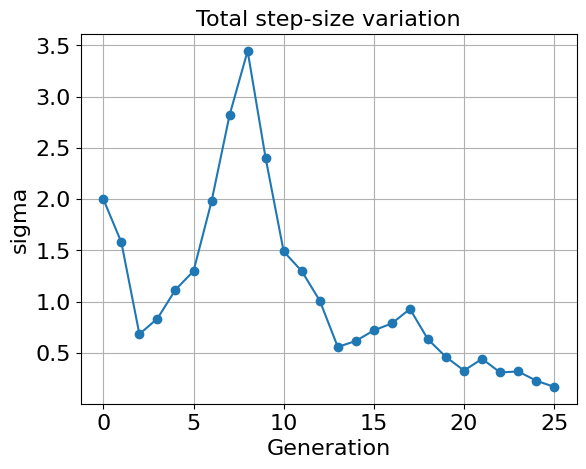



Sigma variation of CSA (both happen)
[1.9283486149811735, 1.2820792274682986, 0.8339770684552845, 1.1149460566373615, 1.2973818702106668, 1.9777399471663466, 2.8203630790036245, 3.446633793376636, 3.335053836134275, 2.051467004609721, 1.4419104573865713, 1.144008425425847, 0.9069202962610785, 0.6155784471837719, 0.7186766207440309, 0.7866094277963823, 0.9273537382258789, 0.8445437894389055, 0.6250854934878927, 0.44666208282588515, 0.44088183907471107, 0.4076650471876975, 0.31757881007010225, 0.31199455434078965, 0.22535252121559704]


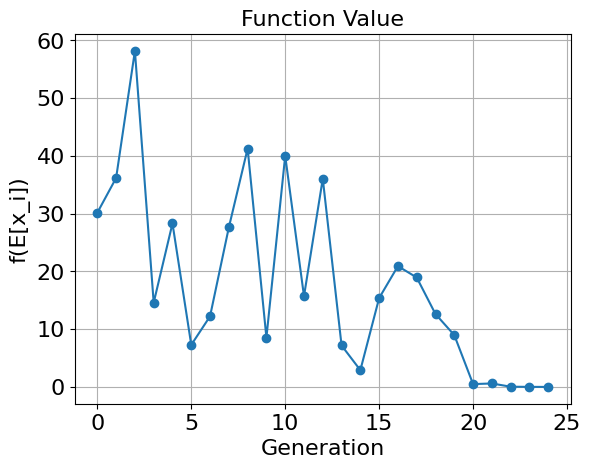

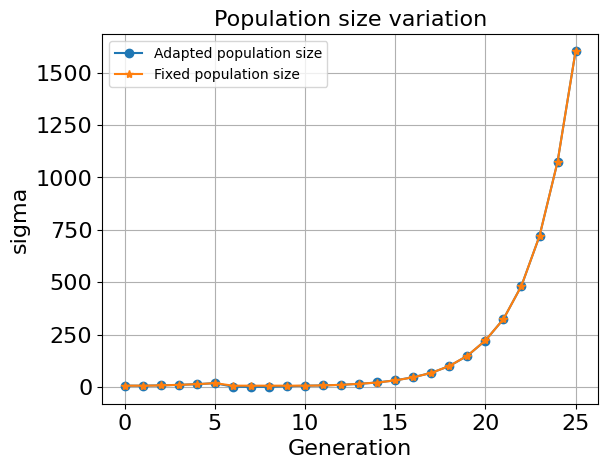



Mean [array([4.92057755, 4.21771533]), array([3.88173053, 3.1202944 ]), array([4.12623768, 3.18486349]), array([3.50174208, 2.46942612]), array([2.8912764 , 1.99156019]), array([2.35791551, 1.87410879]), array([0.82350928, 0.97713857]), array([-0.81622003, -0.83505225]), array([-2.42167859, -0.89395431]), array([-2.36703856, -0.42055478]), array([-1.91259978, -1.10713829]), array([-1.53738169,  0.3916746 ]), array([-0.91638023,  0.3056841 ]), array([-1.3172004 ,  0.51424137]), array([-1.10069881,  0.14778609]), array([-0.95990806, -0.0929225 ]), array([-0.70278986, -0.10143466]), array([-0.44305335,  0.08350882]), array([-0.40496319,  0.05110178]), array([-0.28883154,  0.02396772]), array([-0.23218868,  0.01264871]), array([-0.04984319,  0.00175715]), array([-0.05528371, -0.00098523]), array([-0.01347742,  0.00214237]), array([-0.00038094, -0.00779328]), array([0.00287292, 0.00037665])]


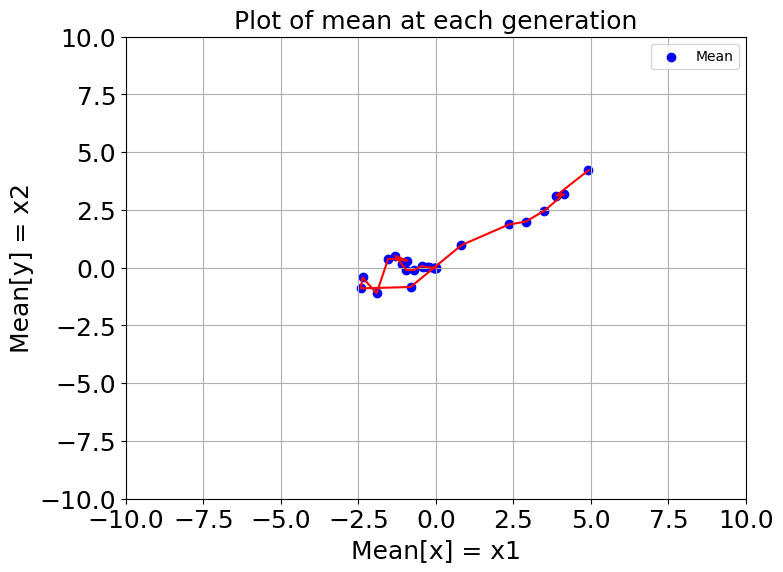

In [ ]:
print("Total sigma variation")
print(sigTot)


plt.figure(1)
plt.plot(sigTot, marker='o', linestyle='-',label='step-size')
# plt.plot(sigCSA, marker='>', linestyle='-')
# plt.plot(range(len(sigTot)), sigTot, marker='o', linestyle='-')
plt.title('Total step-size variation', fontsize=16)
plt.xlabel('Generation',fontsize=16)
plt.ylabel('sigma',fontsize=16)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

plt.show()

print("\n")
print("Sigma variation of CSA (both happen)")
print(sigCSA)

plt.figure(2)
plt.plot(F, marker='o', linestyle='-')
plt.title('Function Value',fontsize=16)
plt.xlabel('Generation',fontsize=16)
plt.ylabel('f(E[x_i])',fontsize=16)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

print("\n")


plt.figure(3)
plt.plot(real_l, marker='o', linestyle='-', label='Adapted population size')
plt.plot(fixed_l, marker='*', linestyle='-',label='Fixed population size')
# plt.plot(range(len(sigTot)), sigTot, marker='o', linestyle='-')
plt.title('Population size variation', fontsize=16)
plt.xlabel('Generation',fontsize=16)
plt.ylabel('sigma',fontsize=16)
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

plt.show()



print("\n")
print("Mean", Mean)
Mean = np.array(Mean)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(Mean[:, 0], Mean[:, 1], color='blue', label='Mean')
ax.plot(Mean[:, 0], Mean[:, 1], color='red')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

# set axis labels and title
plt.xlabel('Mean[x] = x1',fontsize=18)
plt.ylabel('Mean[y] = x2',fontsize=18)
plt.title('Plot of mean at each generation',fontsize=18)
plt.legend()
plt.grid()

# show plot
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

In [ ]:
import numpy as np
import random
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import multivariate_normal, chi2
import time
import pandas as pd


# scval = [0.6, 0.8, 0.9, 1]

# for scale_val in range(len(scval)):

p = 0

Feval = []
F_final = []
Ngen = []
CPU = []
Scale = []

while p<100:

    # Define the intervals
    x_interval = [10, 100]
    y_interval = [10, 100]

    # Generate a random x coordinate within the specified interval
    x_coordinate = random.uniform(x_interval[0], x_interval[1])

    # Generate a random y coordinate within the specified interval
    y_coordinate = random.uniform(y_interval[0], y_interval[1])

    # Create a NumPy array representing the sampled point
    sampled_point = np.array([x_coordinate, y_coordinate])

    # sampled_point = np.array([29.14552297, 63.06347629])

    print("Sampled Point:", sampled_point)


  # Define the interval
    interval = [10, 100]

    # Calculate half of the interval length
    half_interval_length = (interval[1] - interval[0]) / 2

    # Print the result
    print("Half of the interval length:", half_interval_length)




    g = 200 # no. of generations to run (no. of iterations)
    k = 0  # iteration count
    n = 2  # no. of variables in the objective function (dimension)
    l_def = l_ng = l = 4 + math.floor(3*np.log(n))
    l_max = 512*l_def


    F=[]        # To store the function value at each iteration
    Mean = []   # To store the mean value at each iteration
    Cov = []    # To store the covariance matrix at each iteration
    ch = []     # To store the shift in mean at each iteration
    pop = []    # To store the population size at every generation
    sigCSA = [] # To store the step size change by CSA at every generation
    sigTot = [] # To store the total step size change at every generation (step-size correction)
    real_l = [] # To store the found l value
    fixed_l = [] # considered l
    pthetval = []
    psignorm = [] # To consider psignorm values
    hsigma = []
    psigvec = []
    st_sng = []
    st_spg = []
    st_div = []
    adapt = []
    potsig = []
    inval_pg = []
    inval_ng = []
    normval_pg = []
    normval_ng = []

    l_ng = l_def   # population size starts with default population size
    I = l_ng      # Initial population = I

#     m = np.array([1, 1])
#     c = np.array([[1, 0], [0, 1]])
#     zero = np.array([0,0])
#     psigng = np.array([0,0])
#     pcng = np.array([0,0])     # Because pc = 0 at gen 0
#     p_thetng = np.array([0,0,0,0,0]) # Because p_theta = 0 at gen 0

    m = sampled_point
    c = np.eye(2)
    sig = half_interval_length

    zero = np.zeros(n)
    psigng = np.zeros(n)
    pcng = np.zeros(n)     # Because pc = 0 at gen 0
    p_thetng = np.zeros(int(n*(n+3)/2)) # Because p_theta = 0 at gen 0

    Mean.append(m)
    Cov.append(c)

    real_l.append(l)
    fixed_l.append(l_ng)
    psigvec.append(psigng)

    gam_signg = 0      # normalization factor for p_sigma
    gam_cng = 0        # normalization factor for pc
    gam_thetng = 0     # normalization factor for p_theta
    alpha = 1.4        # for PSA update - population size correction
    beta = 0.4         # for PSA update - p_theta update

    sigTot.append(sig)

    start_time = time.process_time()

    while k<g:

        I = l_ng
        pc = pcng          # pc equals the pc of next generation
        psig = psigng      # psig equals the psig of next generation
        p_thet = p_thetng  # p_theta equals the p_theta of next generation
        gam_sig = gam_signg
        gam_c = gam_cng
        gam_thet = gam_thetng


        # assigning weights

        mu = math.floor(I/2)
        w_k = []       # weight vector - contains weights for all I
        denom = 0      # denominator for eack w_k_i
        for i in range(1,mu+1):
            denom = denom + (np.log((mu+0.5)) - np.log(i))

        for i in range(1, mu + 1):
            w_k_i = (np.log((mu + 0.5)) - np.log(i)) / denom
            w_k.append(w_k_i)
        for i in range(mu+1,I+1):
            w_k_i = 0
            w_k.append(w_k_i)

        # define mu_eff, c1, c_mu, c_sig, d_sig, cm, Cc

        mu_eff = 1 / np.sum(np.square(w_k))                            # mu_eff = 1/sum(w_i**2)
        c1 = 2/((n+1.3)**2 + mu_eff)                                   # Value from 2018 paper
        c_mu = min(1, (2*(mu_eff - 2 +1)/mu_eff)/((n+2)**2 + mu_eff))  # min(1, (2(mu_eff - 2 +1)/mu_eff)/((n+2)**2 + mu_eff))
        c_sig = (mu_eff+2)/(n+mu_eff+5)
        d_sig = 1 + c_sig  + 2*(max(0, (np.sqrt((mu_eff-1)/(n+1))-1))) # 1 + c_sig + 2*max{ 0, sqrt((mu_eff-1)/(n+1))-1 }
        cm = 1                                                         # Learning parameter is set to 1
        Cc = (4 + (mu_eff/n))/(n + 4 + (2*mu_eff/n))                   # Cc (value from 2018 PSA_CMA_ES paper)

        px=[]
        py=[]

        while(len(px)<I):
            d =  m + sig * np.random.multivariate_normal(zero, c)
            if (d[0] <= 100) and (d[1] <= 100) and (d[0] >= -100) and (d[1] >= -100):
                px.append(d[0])
                py.append(d[1])

        # keep old values
        mpg = m       # old m value
        c_old = c     # old c value
        sigpg = sig   # old sig value


        # select i:l_r values

        b = [(x**2 + y**2)**(1/4) * (np.sin(50*((x**2 + y**2)**(0.1)))**2 + 1) for x, y in zip(px, py)]    # Calculate the sum of each px[i]+py[i] and store in list b

        best = sorted(b)     # Sort b in lows

        bx = [px[b.index(val)] for val in best]    # Find the corresponding px[i] and py[i]
        by = [py[b.index(val)] for val in best]    #       values for each element in 'best'

        print("\n")
#         print("Candidate solutions")
#         for i in range(len(bx)):
#             print("At ",k,": (",bx[i],",",by[i],")")

        bestx = []
        besty = []
        for i in range(len(bx)):
            bbx = w_k[i]*(bx[i] - m[0])
            bby = w_k[i]*(by[i] - m[1])
            bestx.append(bbx)
            besty.append(bby)

        dmx = cm * sum(bestx)
        dmy = cm * sum(besty)

        # mean vector update

        mx = m[0] + dmx      # update vector m - x-coordinate
        my = m[1] + dmy      # update vector m - y-coordinate

        m = np.array([mx,my])  # m - next generation

#         print("\n")
        print("Mean for ",k+1," = ",m)


        ch.append(m-mpg)   #To calculate the change in mean at each iteration

#         print("m[",k+1,"] - m[",k,"]", ch[k])


#         plt.figure(2*k)
#         plt.scatter(px, py, color='b', label='{}th population'.format(k+1))
#         plt.scatter(m[0], m[1], color='r', label='Mean at {}th generation'.format(k+1))
#         plt.xlabel('X')
#         plt.ylabel('Y')
#         plt.title('x[{}] th generation'.format(k + 1))
#         plt.legend()
#         plt.grid()

        # Getting the eigendecompostion of c for the CSA update

#         print("\n")
#         print("p_sigma path signal understanding")
        eigenvalues, eigenvectors = np.linalg.eig(c) # Eigendecomposition of c
        if any(eigval < 0 for eigval in eigenvalues):
            print("At k=",k+1,", matrix is not PSD")
        B = eigenvectors                             # Ensure eigenvectors are normalized (orthogonal matrix)
#         print("Eigenvectors: ")
#         print(B)
        D = np.diag(np.sqrt(eigenvalues))            # Diagonal matrix D with square roots of eigenvalues
#         print("Eigenvalues")
#         print(D)
        D_inv = np.diag(1 / np.sqrt(eigenvalues))    # Calculate the inverse of D
        c_inv_half = B @ D_inv @ B.T                 # Calculate C^(-1/2) = B * D^(-1) * B^T
#         print("c_inv_half")
#         print(c_inv_half)



        # Evolution path p_sigma for CSA update (p_sigma is 2x1)

        psigng0 = (1-c_sig)*psig[0] + math.sqrt((c_sig*(2 - c_sig)*mu_eff))*(1/sig)*(c_inv_half[0][0]*dmx + c_inv_half[0][1]*dmy)
        psigng1 = (1-c_sig)*psig[1] + math.sqrt((c_sig*(2 - c_sig)*mu_eff))*(1/sig)*(c_inv_half[1][0]*dmx + c_inv_half[1][1]*dmy)
        gam_signg = ((1-c_sig)**2)*gam_sig + c_sig*(2-c_sig)   # normalization p_sigma

        psigng = np.array([psigng0,psigng1])

        psigvec.append(psigng)

#         print("\n")
#         print("Evolution path p_sigma = ",psigng)

        # Evolution path pc for rank-one update (pc is 2x1)

        chi = (math.sqrt(n))*(1 - (1/(4*n)) + (1/(21*n**2))) # E[||N(0,I)||]
        psig_vector = np.array([[psigng[0]], [psigng[1]]])   # Define a psigng as a 2x1 matrix
        norm_psig = np.linalg.norm(psig_vector)              # Calculate the 2-norm (Euclidean norm)

#         print("\n")
#         if norm_psig < chi:
#             print("norm_psig < expected length --> CSA decreased")
#         else:
#             print("norm_psig >= expected length --> CSA increased")
        cond = (1.4 + 2/(n+1))*chi*(math.sqrt(gam_signg))    # condition for h_sigma

        psignorm.append(norm_psig)

        if norm_psig<cond:
            h_sig = 1
        else:
            h_sig = 0

        hsigma.append(h_sig)

        pcng0 = (1-Cc)*pc[0] + h_sig*(math.sqrt((Cc*(2 - Cc)*mu_eff)))*(1/sig)*dmx  # x-coordinate
        pcng1 = (1-Cc)*pc[1] + h_sig*(math.sqrt((Cc*(2 - Cc)*mu_eff)))*(1/sig)*dmy  # y-coordinate
        gam_cng = ((1-Cc)**2)*gam_c + h_sig*Cc*(2-Cc)   # normalization pc

        pcng = np.array([pcng0,pcng1])

        sigA = sig

        # step size update (sigma)

        exp_val = (c_sig/d_sig)*((norm_psig/chi) - (math.sqrt(gam_signg)))
        sig = sig*(math.exp(exp_val))

        sigB = sig

#         print("||P_sig||/chi = ",(norm_psig/chi))
#         print("\n")
#         print("sig * exp(",exp_val,")")
#         print("step-size after CSA correction : ")
#         print(sig)

        sigCSA.append(sig)



        # rank-mu update

        dift_x = []  # string to hold x - m := x-coordinate
        dift_y = []  # string to hold x - m := y-coordinate
        cmat00 = []  # 00 element of (x-m).(x-m)^T outer product
        cmat01 = []  # 01 element of (x-m).(x-m)^T outer product
        cmat10 = []  # 10 element of (x-m).(x-m)^T outer product
        cmat11 = []  # 11 element of (x-m).(x-m)^T outer product

        for i in range(len(bx)):
            difx = bx[i] - m[0]
            dify = by[i] - m[1]
            dift_x.append(difx)
            dift_y.append(dify)
        for i in range(len(bx)):
            c00 = w_k[i]*(dift_x[i]*dift_x[i] - c[0][0])
            c01 = w_k[i]*(dift_x[i]*dift_y[i] - c[0][1])
            c10 = w_k[i]*(dift_x[i]*dift_y[i] - c[1][0])
            c11 = w_k[i]*(dift_y[i]*dift_y[i] - c[1][1])
            cmat00.append(c00)
            cmat01.append(c01)
            cmat10.append(c10)
            cmat11.append(c11)

        cRank_mu = np.zeros((2,2))
        cRank_mu[0][0] = sum(cmat00)
        cRank_mu[0][1] = sum(cmat01)
        cRank_mu[1][0] = sum(cmat10)
        cRank_mu[1][1] = sum(cmat11)


        # rank-one update

        cRank_1 = np.zeros((2,2))
        cRank_1[0][0] = pcng[0]*pcng[0] - gam_cng*c[0][0]
        cRank_1[0][1] = pcng[0]*pcng[1] - gam_cng*c[0][1]
        cRank_1[1][0] = pcng[1]*pcng[0] - gam_cng*c[1][0]
        cRank_1[1][1] = pcng[1]*pcng[1] - gam_cng*c[1][1]

        # Covariance matrix update

        c = c + c1*cRank_1 + c_mu*cRank_mu



        ##    ***  PSA update  ***

        # 1 - Approximate FIM

        fim = c_inv_half

        # 2 - Calculate Deltha_Theta

        dtheta = np.array([0,0,0,0,0])
        dtheta0 = fim[0][0]*(dmx) + fim[0][1]*(dmy)
        dtheta1 = fim[0][1]*(dmx) + fim[1][1]*(dmy)
        dtheta2 = (sig**2)*(c[0][0]) - (sigpg**2)*(c_old[0][0])
        dtheta3 = (sig**2)*(c[0][1]) - (sigpg**2)*(c_old[0][1])
        dtheta4 = (sig**2)*(c[1][1]) - (sigpg**2)*(c_old[1][1])

#         print("\n")
#         print("I^(1/2)*Dtheta (5x1)-vector")


        dtheta = np.array([dtheta0,dtheta1,dtheta2,dtheta3,dtheta4])

#         print("     dmx         dmy    sig*dC[0][0] sig*dC[0][1] sig*dC[1][1]")
#         print(dtheta)

        # 3 - Find terms of E[ ||.|| ]

        w_k_i3 = 0                        # sum(wi^3)
        for i in range(len(w_k)):
            w_k_i3 = w_k_i3 + w_k[i]**3

        E1  = n*(cm**2)/mu_eff
        E2  = (2*n)*((n - chi**2)/(chi**2))*gam_signg*((c_sig/d_sig)**2)
        E3a = (n**2 + n)*(c_mu**2)/mu_eff
        E3b = (n**2 + n)*(Cc)*(2 - Cc)*(c1)*(c_mu)*(mu_eff)*(w_k_i3)
        E3c = (c1**2)*(gam_cng**2)*(n**2)
        E3d = 1 - (2*gam_cng) + 2*n*(gam_cng**2)
        E3e = 1 + (8*(gam_signg)*((n - chi**2)/(chi**2))*((c_sig/d_sig)**2))
        E3  = (1/2)*E3e*(E3a + E3b + E3c + E3d)

        # 4 - Approximation for E[ ||.|| ]

        Efim = E1 + E2 + E3

        Efim_rt = math.sqrt(Efim)  # E[|| fim.dtheta ||]^(1/2)

        # Evolution path p_theta for PSA update (p_theta is 5x1) ( R^(n(n+3)/2) )

        p_thetng0 = (1 - beta)*p_thet[0] + (1/Efim_rt)*(math.sqrt((beta*(2 - beta))))*(dtheta[0])
        p_thetng1 = (1 - beta)*p_thet[1] + (1/Efim_rt)*(math.sqrt((beta*(2 - beta))))*(dtheta[1])
        p_thetng2 = (1 - beta)*p_thet[2] + (1/Efim_rt)*(math.sqrt((beta*(2 - beta))))*(dtheta[2])
        p_thetng3 = (1 - beta)*p_thet[3] + (1/Efim_rt)*(math.sqrt((beta*(2 - beta))))*(dtheta[3])
        p_thetng4 = (1 - beta)*p_thet[4] + (1/Efim_rt)*(math.sqrt((beta*(2 - beta))))*(dtheta[4])

        gam_thetng = ((1 - beta)**2)*gam_thet + beta*(2 - beta)
        # p_thetng = np.array([[p_thetng0], [p_thetng1], [p_thetng2], [p_thetng3], [p_thetng4]])
        p_thetngval = p_thetng0**2 + p_thetng1**2 + p_thetng2**2 + p_thetng3**2 + p_thetng4**2

#         print("p_theta evolution path (5x1)")
#         print(p_thetng)

        # Update population size

        # norm_pthet = np.linalg.norm(p_thetng)     # Calculate the 2-norm (Euclidean norm) of p_theta
        norm_pthet = math.sqrt(p_thetngval)

        exp_val2 = beta*(gam_thetng - (norm_pthet**2)/alpha)

#         print("beta*exp(val2)")
#         print("val2 = ",(gam_thetng - (norm_pthet**2)/alpha))

#         print("norm of ptheta = ",norm_pthet)
#         print("\n")

        pthetval.append(norm_pthet)

        l = l*math.exp(exp_val2)

#         print("real l = ",l)
        reall=l
        real_l.append(l)

        l = min(max(l,l_def),l_max)
        l_pg = l_ng   # keep old population size
        l_ng = round(l)

        fixed_l.append(l_ng)


#         print("fixd l = ",l_ng)

#         print("\n")
#         print("Step size correction")

        # step size correction

        # Generating (lamda_r)^(t+1) to find E[N_i:Lr]

        lpx = []
        lpy = []

        while(len(lpx)<l_ng):
            ld =  m + sig * np.random.multivariate_normal(zero, c)
            if (ld[0] <= 100) and (ld[1] <= 100) and (ld[0] >= -100) and (ld[1] >= -100):
                lpx.append(ld[0])
                lpy.append(ld[1])

        lb = [(x**2 + y**2)**(1/4) * (np.sin(50*((x**2 + y**2)**(0.1)))**2 + 1) for x, y in zip(lpx, lpy)]    # Calculate the sum of each px[i]+py[i] and store in list b

        lbest = sorted(lb)     # Sort b in lows

        lbx = [lpx[lb.index(val)] for val in lbest]    # Find the corresponding px[i] and py[i]
        lby = [lpy[lb.index(val)] for val in lbest]    #       values for each element in 'best'

        # weights for (lamda_r)^(t+1)
        lw_k = []       # weight vector - contains weights for all I
        ldenom = 0      # denominator for eack w_k_i
        lmu = math.floor(l_ng/2)
        for i in range(1,l_ng+1):
            ldenom = ldenom + (np.log((l_ng+0.5)) - np.log(i))

        for i in range(1, lmu + 1):
            lw_k_i = (np.log((l_ng + 0.5)) - np.log(i)) / ldenom
            lw_k.append(lw_k_i)
        for i in range(lmu+1,l_ng+1):
            lw_k_i = 0
            lw_k.append(lw_k_i)

        lmu_eff = 1 / np.sum(np.square(lw_k))

        #finding phi^(-1)
        al = 0.375
        prob_pg = []
        prob_ng = []

        inval_pg = []
        normval_pg = []

        for i in range(len(bx)):
            valp = (i+1-al)/(len(bx)+1-2*al)
            inval_pg.append(valp)
            phipg = norm.ppf(valp)
            normval_pg.append(phipg)

            mxppg = w_k[i]*(mpg[0] + sigpg*(phipg))
            myppg = w_k[i]*(mpg[1] + sigpg*(phipg))
            exp_pg = math.sqrt((mxppg**2 + myppg**2))
            prob_pg.append(exp_pg)


#             mxppg = w_k[i]*(mpg[0] + sigpg*(norm.ppf((i+1)/(len(bx)+1))))
#             myppg = w_k[i]*(mpg[1] + sigpg*(norm.ppf((i+1)/(len(bx)+1))))
#             exp_pg = math.sqrt((mxppg**2 + myppg**2))
#             prob_pg.append(exp_pg)
            #exp_pg = mxppg

#         print("\n")
#         print("At generation",k,"P(x) value for L_g =")
#         print(inval_pg)
#         print("At generation",k,"phi(-1) value for L_g =")
#         print(normval_pg)
#         print("\n")


        inval_ng = []
        normval_ng = []

        for i in range(len(lbx)):
            valn = (i+1-al)/(len(lbx)+1-2*al)
            inval_ng.append(valn)
            phing = norm.ppf(valn)
            normval_ng.append(phing)

            mxpng = lw_k[i]*(m[0] + sig*(phing))
            mypng = lw_k[i]*(m[1] + sig*(phing))
            exp_ng = math.sqrt((mxpng**2 + mypng**2))
            prob_ng.append(exp_ng)

#             mxpng = lw_k[i]*(m[0] + sig*(norm.ppf((i+1)/(len(lbx)+1))))
#             mypng = lw_k[i]*(m[1] + sig*(norm.ppf((i+1)/(len(lbx)+1))))
#             exp_ng = math.sqrt((mxpng**2 + mypng**2))
#             #exp_ng = mxpng
#             prob_ng.append(exp_ng)
#         print("\n")
#         print("At generation",k,"P(x) value for L_g+1 =")
#         print(inval_ng)
#         print("At generation",k,"phi(-1) value for L_g+1 =")
#         print(normval_ng)
#         print("\n")


#         print("phi^(-1)_pg = ",phipg)
#         print("phi^(-1)_ng = ",phing)

#         print("\n")

#         print("weighted expected values of NOS")
#         print("\n")

#         print("E[l_r^(g)] = ",prob_pg)
#         print("E[l_r^(g+1)] = ",prob_ng)

#         print("sum{E[l_r^(g)]} = ",sum(prob_pg))
#         print("sum{E[l_r^(g+1)]} = ",sum(prob_ng))

#         print("\n")

        cpg = (-1)*sum(prob_pg)
        cng = (-1)*sum(prob_ng)
        sigfunc_pg = (cpg*n*mu_eff)/(n - 1 + (cpg**2)*mu_eff)
        sigfunc_ng = (cng*n*lmu_eff)/(n - 1 + (cng**2)*lmu_eff)

#         print("lr(g+1) = ",sigfunc_ng)
#         print("lr(g) = ",sigfunc_pg)
#         print("lr(g+1)/lr(g) = ",sigfunc_ng/sigfunc_pg)
#         print("\n")
#         print("st-s b4 correction = ",sig)
        # step size correction

        st_sng.append(sigfunc_ng)
        st_spg.append(sigfunc_pg)
        st_div.append(sigfunc_ng/sigfunc_pg)


        # # ORIGINAL
        # #sig = sig*((scval[scale_val])*(sigfunc_ng/sigfunc_pg))
        # sig = sig*((sigfunc_ng/sigfunc_pg))


        # CASE 1
        if abs(l_ng - l_pg) < 2.5:
            if norm_psig >= chi:
                sig = sig
                print("step-size correction not done as CSA request step-size increase")
            else:
                sig = sig*(0.5*(sigfunc_ng/sigfunc_pg))
                print("scaled step-size correction (pop-dif < 10)")

        else:
            if norm_psig >= chi:
                sig = sig
                print("step-size correction not done as CSA request step-size increase")
            else:
                sig = sig*((sigfunc_ng/sigfunc_pg))
                print("unscaled step-size correction")




        # # CASE 2
        # if norm_psig >= chi:
        #     sig = sig
        # else:
        #     sig = sig*(0.5*(sigfunc_ng/sigfunc_pg))





        sigTot.append(sig)



        f = (mx**2 + my**2)**(1/4) * (np.sin(50*((mx**2 + my**2)**(0.1)))**2 + 1)   # function value - to plot

        F.append(f)
        Mean.append(m)
        Cov.append(c)

#         print("\n")
        print("Covariance matrix for ",k+1)
        print(c)


#         # Create a grid of x and y values
#         x = np.linspace(-10, 10, 500)
#         y = np.linspace(-10, 10, 500)
#         X, Y = np.meshgrid(x, y)

#         Z = np.exp(-(np.square(X - m[0]) * c[0, 0] +
#                  (X - m[0]) * (Y - m[1]) * c[0, 1] +
#                  np.square(Y - m[1]) * c[1, 1])) / (2 * np.pi * np.sqrt(np.linalg.det(c)))

#         # Plot the 2D Gaussian distribution
#         plt.figure(3*k+1)
#         plt.figure(figsize=(8, 6))
#         plt.contourf(X, Y, Z, levels=10, cmap='Reds')
#         plt.colorbar()
#         plt.scatter(px, py, color='cyan', alpha=0.4, label='xk({})'.format(k+1))
#         plt.scatter(m[0], m[1], color='yellow', label='Mean at {}th generation'.format(k+1))
#         plt.xlabel('X',fontsize=14)
#         plt.ylabel('Y',fontsize=14)
#         plt.tick_params(axis='both', which='major', labelsize=16)
#         plt.title('2D Gaussian Distribution for generation {}'.format(k+1),fontsize=16)
#         plt.grid(True)
#         plt.show()





        # # Generate random points from multivariate normal distribution
        # num_points = len(px)
        # points = np.random.multivariate_normal(m, c, num_points)
        # px, py = points[:, 0], points[:, 1]

        # # Create a multivariate normal distribution object
        # mv_normal = multivariate_normal(mean=m, cov=c)

        # # Define confidence level
        # confidence_level = 0.95

        # # Degrees of freedom for the chi-squared distribution
        # df = len(m)

        # # Calculate critical value for the confidence interval
        # critical_value = chi2.ppf(confidence_level, df)

        # # Plot points
        # plt.scatter(px, py, color='blue')

        # # Plot contours
        # x, y = np.mgrid[-10:10:.01, -10:10:.01]
        # pos = np.dstack((x, y))
        # contour_levels = mv_normal.pdf(pos)
        # plt.contour(x, y, contour_levels, colors='blue',alpha=0.4)

        # # Plot critical value contour
        # plt.contour(x, y, mv_normal.pdf(pos), levels=[mv_normal.pdf(critical_value)], colors='green')

        # # Plot contour with radius determined by sig
        # plt.contour(x, y, contour_levels, levels=[mv_normal.pdf(sig)], colors='red',linestyles='dashed')

        # # Identify points inside and outside the confidence interval
        # inside_points = points[np.where(mv_normal.pdf(points) >= mv_normal.pdf(critical_value))]
        # outside_points = points[np.where(mv_normal.pdf(points) < mv_normal.pdf(critical_value))]

        # # Highlight points
        # plt.scatter(inside_points[:, 0], inside_points[:, 1], color='green', label='Inside Confidence Interval')
        # plt.scatter(outside_points[:, 0], outside_points[:, 1], color='red', label='Outside Confidence Interval')

        # plt.scatter(m[0], m[1], color='yellow', label='Mean at {}th generation'.format(k+1))

        # # Add legend
        # plt.legend()

        # # Show plot
        # plt.xlabel('X')
        # plt.ylabel('Y')
        # plt.title('2D Gaussian Distribution for generation {}'.format(k+1),fontsize=16)
        # plt.grid(True)
        # plt.show()







        if abs(F[k] - 0.0)<10**(-2):
            break

        k = k+1

    end_time = time.process_time()

    print("\n")

    cpu_time = end_time - start_time
    print("CPU time for the loop:", cpu_time)

    print("run ",p," : fun_vals = ",F)
    print("No. of gen to cng = ",len(F))
    print("Final value reached = ",F[-1])
    # print(fixed_l)
    avgfeval = (sum(fixed_l)/len(fixed_l))
    print("Avg # f.eval = ",avgfeval)

    Feval.append(avgfeval)
    F_final.append(F[-1])
    Ngen.append(len(F))
    CPU.append(cpu_time)
    # Scale.append(scval[scale_val])
    print("\n")
    print("\n")
    print("\n")
    print("\n")
    p = p+1

    print("\n")

print("No. of gen to cng = ",Ngen)
print("Final value reached = ",F_final)
print("Avg # f.eval = ",Feval)
print("CPU time for loop = ",CPU)

df = pd.DataFrame({
    'cpu_time': CPU,
    'F_final': F_final,
    'Feval': Feval,
    'Ngen': Ngen



})

# Save the DataFrame to an Excel file
df.to_excel('output.xlsx', index=False)
    # filename = f'output_{scale_val}.xlsx'
    # df.to_excel(filename, index=False)

Streaming output truncated to the last 5000 lines.
 [0.38621109 1.10511025]]


Mean for  98  =  [1.38901401 7.55188181]
scaled step-size correction (pop-dif < 10)
Covariance matrix for  98
[[ 6.79540342 -1.19263861]
 [-1.19263861  3.00980166]]


Mean for  99  =  [0.74105131 5.117171  ]
scaled step-size correction (pop-dif < 10)
Covariance matrix for  99
[[24.4447369  -2.39492213]
 [-2.39492213  6.17040824]]


Mean for  100  =  [0.81013159 0.10483072]
scaled step-size correction (pop-dif < 10)
Covariance matrix for  100
[[ 64.50220619 -10.13589829]
 [-10.13589829  11.27539014]]


Mean for  101  =  [12.56639058  2.03928303]
scaled step-size correction (pop-dif < 10)
Covariance matrix for  101
[[65.46852147 -8.04200821]
 [-8.04200821 11.53627269]]


Mean for  102  =  [8.19407548 0.85828651]
scaled step-size correction (pop-dif < 10)
Covariance matrix for  102
[[55.18717472 -6.93322878]
 [-6.93322878  9.52164709]]


Mean for  103  =  [ 8.33492844 -0.1107944 ]
scaled step-size correction (p

Total sigma variation
[45.0, 51.795643014026055, 31.156108861627654, 13.157071825432139, 26.456848238452682, 6.216051090863008, 2.8711052085122435, 1.9649964351517226, 0.9652640904795246, 0.6059938291901069, 0.7535458327450809, 0.8781774574766257, 0.4794301774041737, 0.666900566116508, 0.6962501694923662, 0.3798958251387096, 0.19613053885699636, 0.24012618453265894, 0.2561634930572589, 0.14717036866598823, 0.18384719710672606, 0.09310163483031546, 0.045038571731918116, 0.024356186827481516, 0.01283082214216488, 0.006460211505623463, 0.0034730498518490793, 0.003477700503051418, 0.001945602574968139, 0.0011398744480711194, 0.0006633719472726425, 0.00038042640624289317, 0.00021392032567549898, 0.00021596422451346735, 0.00012498728638209852, 7.181071524633676e-05, 4.1646096213229936e-05, 2.4559511698410013e-05, 2.5191619194344557e-05, 1.4628992037180228e-05, 1.490283488630329e-05, 8.58015664620498e-06, 4.936091662907074e-06, 2.8638706887230474e-06, 1.6590517071858847e-06, 9.625445335723314

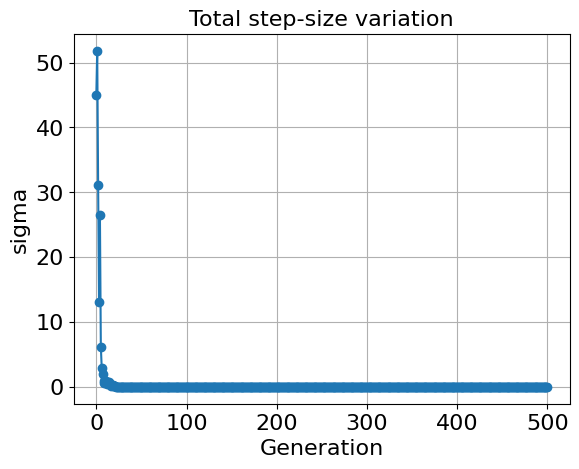



Sigma variation of CSA (both happen)
[51.795643014026055, 50.60150783491552, 29.196335345147297, 10.451146495670931, 21.588364293390136, 5.319635751307326, 2.6457403058125704, 1.6291075165661892, 0.9371809621769559, 0.7535458327450809, 0.8781774574766257, 0.817193410163546, 0.666900566116508, 0.6962501694923662, 0.6705043998254681, 0.3244520424804491, 0.24012618453265894, 0.2561634930572589, 0.24425122490787868, 0.18384719710672606, 0.14938586407944301, 0.07526631277109146, 0.04021143670673532, 0.02156199659912008, 0.010807974311743301, 0.005831552299156411, 0.003477700503051418, 0.0032873004987172562, 0.0019270455569404246, 0.0011219622951043542, 0.0006436143910806663, 0.000361997036277686, 0.00021596422451346735, 0.00021152608170257225, 0.00012155883142663384, 7.049713964053328e-05, 4.157352546843845e-05, 2.5191619194344557e-05, 2.476346987011511e-05, 1.490283488630329e-05, 1.452420228156383e-05, 8.355650695982014e-06, 4.8478643205658984e-06, 2.8083870964129708e-06, 1.6293630983670

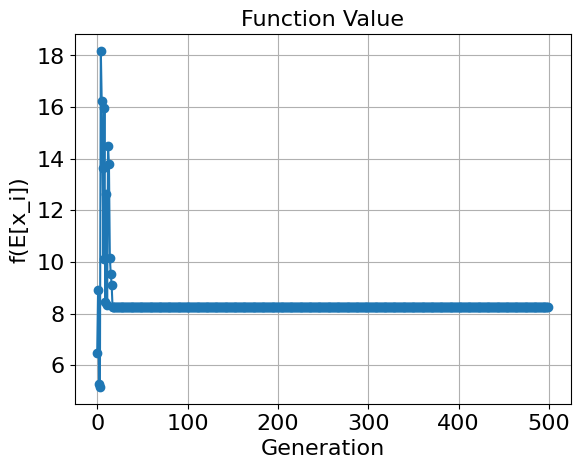

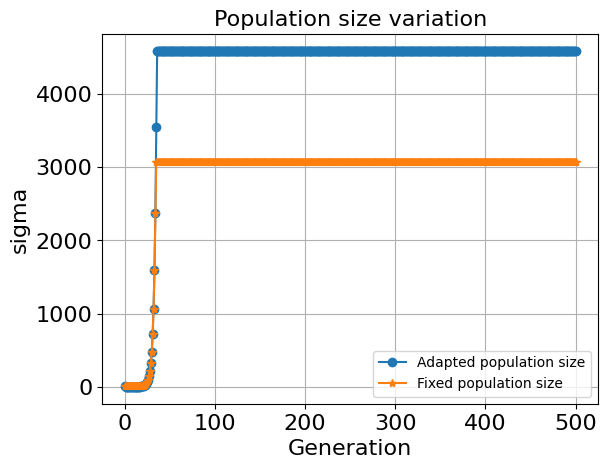



Mean [array([70.51034709, 54.87350251]), array([31.30654091,  7.71861489]), array([-1.07198536, 26.57207857]), array([-18.6844983 ,   8.53664146]), array([6.18306741, 3.58530262]), array([82.49570868,  5.69973272]), array([83.93086763, 37.56563114]), array([73.45359578, 14.25479782]), array([70.45717325, 29.21515352]), array([67.73579355, 23.13296965]), array([62.7526507 , 24.58650953]), array([63.44673145, 16.12610007]), array([66.05133383, 14.36085178]), array([61.32450827, 10.90345564]), array([60.75003025, 12.41082149]), array([63.44086635, 19.60782964]), array([63.89403229, 19.07960716]), array([63.25007839, 21.8215323 ]), array([63.9623576, 22.4970838]), array([64.60407878, 20.58734323]), array([65.0715261 , 19.30787174]), array([64.72475559, 20.57474626]), array([64.63354215, 20.74461628]), array([64.60966584, 20.84661319]), array([64.6045062 , 20.80381973]), array([64.60455955, 20.81201562]), array([64.60668786, 20.80647951]), array([64.60487934, 20.81243779]), array([64.6059

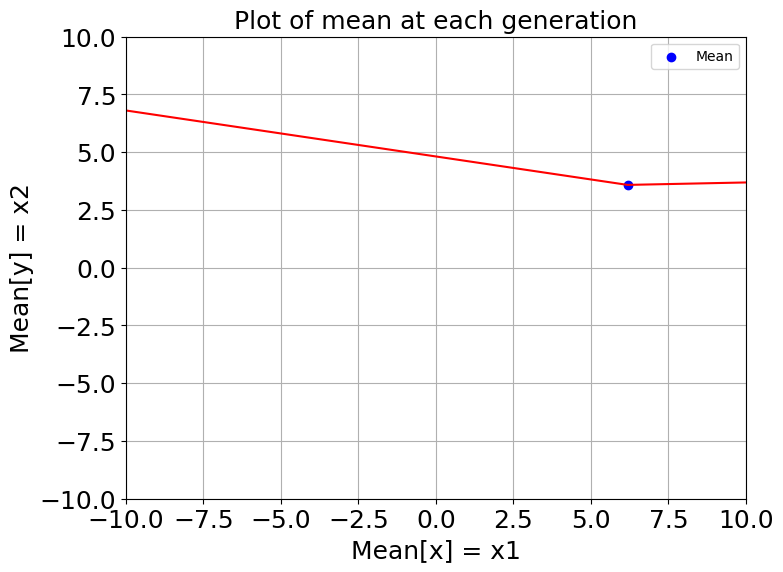

In [ ]:
print("Total sigma variation")
print(sigTot)


plt.figure(1)
plt.plot(sigTot, marker='o', linestyle='-',label='step-size')
# plt.plot(sigCSA, marker='>', linestyle='-')
# plt.plot(range(len(sigTot)), sigTot, marker='o', linestyle='-')
plt.title('Total step-size variation', fontsize=16)
plt.xlabel('Generation',fontsize=16)
plt.ylabel('sigma',fontsize=16)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

plt.show()

print("\n")
print("Sigma variation of CSA (both happen)")
print(sigCSA)

plt.figure(2)
plt.plot(F, marker='o', linestyle='-')
plt.title('Function Value',fontsize=16)
plt.xlabel('Generation',fontsize=16)
plt.ylabel('f(E[x_i])',fontsize=16)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

print("\n")


plt.figure(3)
plt.plot(real_l, marker='o', linestyle='-', label='Adapted population size')
plt.plot(fixed_l, marker='*', linestyle='-',label='Fixed population size')
# plt.plot(range(len(sigTot)), sigTot, marker='o', linestyle='-')
plt.title('Population size variation', fontsize=16)
plt.xlabel('Generation',fontsize=16)
plt.ylabel('sigma',fontsize=16)
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

plt.show()



print("\n")
print("Mean", Mean)
Mean = np.array(Mean)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(Mean[:, 0], Mean[:, 1], color='blue', label='Mean')
ax.plot(Mean[:, 0], Mean[:, 1], color='red')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

# set axis labels and title
plt.xlabel('Mean[x] = x1',fontsize=18)
plt.ylabel('Mean[y] = x2',fontsize=18)
plt.title('Plot of mean at each generation',fontsize=18)
plt.legend()
plt.grid()

# show plot
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()